# MODIS Water XGBOOST Hyperparameter Tuning - Cross Validation

Version: 0.4.0

Date modified: 04.21.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

import xgboost as xgb

import optuna

from sklearn.metrics import accuracy_score, roc_curve, auc, matthews_corrcoef
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
FIGURE_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

training_data_basepath = '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.0.0'

qaMaskPath = '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/adapt/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'

GPU = True
TILE = 'Golden'
MODEL = 'xgboost'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']
# Columns that the user wants to drop for training purposes. 
colsToDrop = []#'sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [3]:
colsToDrop

[]

In [4]:
colsToDropTraining

['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

In [5]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [12]:
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
data_paths = [fv for fv in glob.glob(glob_string)]
data_path = data_paths[0]
pprint(data_paths)

['/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.0.0/MOD09_Golden.0905.1110.1209.1813_1000000_4_0_2.parquet.gzip']


In [7]:
X, y = load_data(fpath=data_path,
                 colsToDrop=colsToDropTraining,
                 dataType=DATA_TYPE,
                 cpu=True,
                 splitXY=True,
                 imbalance=False,
                 trainTestSplit=False,
                 multi=False)

In [8]:
_ = [print(column) for column in X.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [9]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,1000000.0,779.411992,854.975558,-100.0,259.0,512.0,1026.0,16000.0
sur_refl_b02_1,1000000.0,1870.073795,1363.293103,-100.0,543.0,1977.0,2872.0,15825.0
sur_refl_b03_1,1000000.0,541.127729,652.615585,-100.0,186.0,363.0,704.0,12759.0
sur_refl_b04_1,1000000.0,775.668970,696.681392,-100.0,394.0,622.0,983.0,13847.0
sur_refl_b05_1,1000000.0,2021.731733,1316.314378,-100.0,778.0,2221.0,3025.0,9329.0
sur_refl_b06_1,1000000.0,1479.469533,1118.785431,-100.0,547.0,1366.0,2108.0,9770.0
sur_refl_b07_1,1000000.0,873.272946,917.527705,-100.0,253.0,569.0,1177.0,8717.0
ndvi,1000000.0,2486.902390,5630.049435,-32762.0,-71.0,3142.0,6949.0,32679.0
ndwi1,1000000.0,19.312175,4714.783213,-32758.0,-1302.0,1015.0,2960.0,32762.0
ndwi2,1000000.0,2776.884118,5785.573319,-32758.0,458.0,4188.0,6558.0,32762.0


In [10]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [11]:
ndviOverTenK = output_interesting_idx(X, 'ndvi', 10000)
ndviOverTenK

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
119,18,-35,186,245,44,144,117,31176,-16422,-18536
212,7,-29,147,111,-46,125,87,16363,-16041,-20000
340,3,-2,118,105,11,126,72,15536,-10322,-10571
588,-100,2478,-100,41,2493,1145,342,10841,3679,7574
616,19,-11,123,133,-5,17,13,28036,18870,11072
...,...,...,...,...,...,...,...,...,...,...
999376,20,-11,146,117,28,47,28,31092,-16111,-22941
999394,-100,2675,577,626,2232,1029,349,10776,4443,7691
999536,1,-6,107,77,-1,107,97,14000,-11188,-11318
999687,1,-16,130,112,-13,40,19,11333,-23333,14406


## XGBOOST

Choose which combination of hyperparameters to train:

- n_estimators: Number of learners for the xgboost to fit.
- booster: Which booster to use
- lamda: L2 regularization rate
- alpha: L1 regularization rate
- subsample: sampling ration for training data
- colsample_bytree: sampling according to each tree
- max_depth: maximum depth of the tree, signifies complexity
- min_child_weight: minimum child weight, the larger the term, the more complex
- gamme: how selective the algorithm is

In [13]:
def xgb_precision(predt: np.ndarray, dtrain: xgb.DMatrix):
    y = dtrain.get_label()
    tresh_func = np.vectorize(lambda x: 1 if x > 0.5 else 0)
    pred_y = tresh_func(predt)
    precision = precision_score(y, pred_y)
    return 'clf_precision', precision

In [14]:
def objective(trial):
    hyperparameters = {
        "verbosity": 0,
        'disable_default_eval_metric': 1,
        #"learning_rate": 0.001,
        #"objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "hist",
        #"booster":"dart",
        #"rate_drop":0.9,
        "gpu_id": 0,
        "n_jobs": -1,
        "nthread": -1,
        "n_estimators": trial.suggest_categorical("n_estimators", [25, 50, 100, 250, 200, 250, 300, 350, 375, 400]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.1, 0.5),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 0.5),
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth":  trial.suggest_int("max_depth", 3, 15, step=1), 
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight":  trial.suggest_int("min_child_weight", 2, 7), 
        "eta":  trial.suggest_float("eta", 1e-8, 1.0, log=True), 
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True), 
        "grow_policy":  trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")
    training_dmatrix = xgb.DMatrix(data=X, label=y)
    xgb_cv = xgb.cv(dtrain=training_dmatrix, 
                    params=hyperparameters, 
                    nfold=10, 
                    early_stopping_rounds=10,
                    as_pandas=True,
                    feval=xgb_precision)
    test_clf_precision = xgb_cv['test-clf_precision-mean'].values
    print('Cross Validation History: Precision')
    for i, val in enumerate(test_clf_precision):
        print('Fold {}: {}'.format(i, val))
    return np.mean(test_clf_precision)

## Set the search space

Set the search space for the hyperparameter tuning to search through once. This needs to be in conjunction with the `trial.suggest...` part of the hyperparameters dictionary defined aboce. 

Ex.

If `max_depth` is defined in `hyperparameters` in the `objective` function above as such

`"max_depth":  trial.suggest_int("max_depth", 10, 30, step=5),` 

then we need to pair that with the limited search space below as such:

`search_space={"max_depth":[10, 15, 20, 25, 30]}`

This is not the most ideal way of ensuring that trials are not repeated, however it works for now. 

In [15]:
search_space={
    "max_depth":[5, 7, 10, 15],
}

### Set number of trials and timeout

Set the number of trials `n_trials=<num of desired trials>` and the maximum time for the total study `timeout=<timeout in minutes>*60`

In [17]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(study_name='xgboost hyperparameter tuning', 
                            direction='maximize',
                           )#sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective, n_trials=10, timeout=240*60)

[I 2022-04-25 16:21:23,845] A new study created in memory with name: xgboost hyperparameter tuning
[I 2022-04-25 16:22:30,268] Trial 0 finished with value: 0.9429667300000002 and parameters: {'n_estimators': 375, 'booster': 'gbtree', 'lambda': 7.959069396907539e-08, 'alpha': 0.0016197032042423063, 'subsample': 0.47087366069009085, 'colsample_bytree': 0.4488219749351071, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.00015868374381165692, 'gamma': 0.005176624545078743, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9429667300000002.


Cross Validation History: Precision
Fold 0: 0.9383874999999999
Fold 1: 0.9383225000000002
Fold 2: 0.9408909000000001
Fold 3: 0.9418215
Fold 4: 0.9445048
Fold 5: 0.9447080000000001
Fold 6: 0.9458649999999998
Fold 7: 0.9453879000000001
Fold 8: 0.9446729000000001
Fold 9: 0.9451063


[I 2022-04-25 16:23:29,374] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 350, 'booster': 'gbtree', 'lambda': 3.2736466565597503e-05, 'alpha': 0.30634030357118647, 'subsample': 0.3581018305462874, 'colsample_bytree': 0.21957982390195083, 'max_depth': 6, 'min_child_weight': 3, 'eta': 3.050233833835181e-08, 'gamma': 0.0019446626479348787, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9429667300000002.


Cross Validation History: Precision
Fold 0: 0.0
Fold 1: 0.0
Fold 2: 0.0
Fold 3: 0.0
Fold 4: 0.0
Fold 5: 0.0
Fold 6: 0.0
Fold 7: 0.0
Fold 8: 0.0
Fold 9: 0.0


[I 2022-04-25 16:24:38,759] Trial 2 finished with value: 0.9380744199999999 and parameters: {'n_estimators': 50, 'booster': 'gbtree', 'lambda': 6.346858124345331e-05, 'alpha': 0.0003119041895107266, 'subsample': 0.26191435800526797, 'colsample_bytree': 0.3073664518754882, 'max_depth': 13, 'min_child_weight': 7, 'eta': 0.06465313372588172, 'gamma': 0.839675754823024, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.9429667300000002.


Cross Validation History: Precision
Fold 0: 0.9290991
Fold 1: 0.9346025000000001
Fold 2: 0.9344216
Fold 3: 0.9352486000000001
Fold 4: 0.9384900999999999
Fold 5: 0.9394855
Fold 6: 0.94266
Fold 7: 0.9425078000000001
Fold 8: 0.9421423000000001
Fold 9: 0.9420866999999999


[I 2022-04-25 16:25:53,928] Trial 3 finished with value: 0.94519588 and parameters: {'n_estimators': 250, 'booster': 'dart', 'lambda': 0.00024200848216078335, 'alpha': 2.9570425268924946e-06, 'subsample': 0.16368194728876398, 'colsample_bytree': 0.22859022994777622, 'max_depth': 6, 'min_child_weight': 2, 'eta': 0.00031296517435930294, 'gamma': 0.07404786343016091, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.94519588.


Cross Validation History: Precision
Fold 0: 0.9260608999999999
Fold 1: 0.9394176000000002
Fold 2: 0.9316213999999998
Fold 3: 0.9418435000000001
Fold 4: 0.9494298000000001
Fold 5: 0.9505931000000001
Fold 6: 0.9575701000000001
Fold 7: 0.9538317
Fold 8: 0.9514744
Fold 9: 0.9501163


[I 2022-04-25 16:27:07,165] Trial 4 finished with value: 0.9497808000000001 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 0.08780722174549531, 'alpha': 5.044137849495799e-07, 'subsample': 0.18886077034713714, 'colsample_bytree': 0.3861318974020197, 'max_depth': 3, 'min_child_weight': 4, 'eta': 2.561080956484359e-05, 'gamma': 2.3755550668952815e-05, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.9497808000000001.


Cross Validation History: Precision
Fold 0: 0.9301601000000002
Fold 1: 0.9526467999999999
Fold 2: 0.9510525
Fold 3: 0.9478137
Fold 4: 0.9538163
Fold 5: 0.9532775999999998
Fold 6: 0.9558239000000001
Fold 7: 0.9531738000000001
Fold 8: 0.9516169000000001
Fold 9: 0.9484264000000001


[I 2022-04-25 16:29:09,350] Trial 5 finished with value: 0.93947863 and parameters: {'n_estimators': 300, 'booster': 'dart', 'lambda': 0.00047035695434506853, 'alpha': 3.083534519058239e-08, 'subsample': 0.4526965991114824, 'colsample_bytree': 0.4113004572919461, 'max_depth': 13, 'min_child_weight': 7, 'eta': 5.2520022127872226e-05, 'gamma': 7.471037205527818e-05, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.9497808000000001.


Cross Validation History: Precision
Fold 0: 0.9284785
Fold 1: 0.9338058
Fold 2: 0.9378192000000001
Fold 3: 0.9398331000000001
Fold 4: 0.9418219000000001
Fold 5: 0.9411673
Fold 6: 0.9428383
Fold 7: 0.9431290999999999
Fold 8: 0.9425329
Fold 9: 0.9433601999999999


[I 2022-04-25 16:30:22,171] Trial 6 finished with value: 0.9576907499999999 and parameters: {'n_estimators': 200, 'booster': 'dart', 'lambda': 2.0466425002076884e-08, 'alpha': 0.0974017552294485, 'subsample': 0.49497745428756734, 'colsample_bytree': 0.3797625913869255, 'max_depth': 3, 'min_child_weight': 7, 'eta': 2.052993066463671e-07, 'gamma': 3.390688901826367e-08, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.9576907499999999.


Cross Validation History: Precision
Fold 0: 0.9617066999999999
Fold 1: 0.9597017999999998
Fold 2: 0.9551039000000001
Fold 3: 0.9569272
Fold 4: 0.9569067
Fold 5: 0.956641
Fold 6: 0.9609346999999999
Fold 7: 0.9584635
Fold 8: 0.9563517000000001
Fold 9: 0.9541703


[I 2022-04-25 16:31:27,593] Trial 7 finished with value: 0.94082741 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.0011959233600290701, 'alpha': 2.3633397680803136e-07, 'subsample': 0.4900980552359504, 'colsample_bytree': 0.12322909995421259, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.09121026924317913, 'gamma': 1.7875047648361165e-07, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.9576907499999999.


Cross Validation History: Precision
Fold 0: 0.9132909
Fold 1: 0.9344250000000001
Fold 2: 0.9391564000000001
Fold 3: 0.9377679999999999
Fold 4: 0.9456962000000001
Fold 5: 0.9471905000000002
Fold 6: 0.9493423
Fold 7: 0.9493542999999999
Fold 8: 0.9471451999999999
Fold 9: 0.9449053000000001


[I 2022-04-25 16:32:58,920] Trial 8 finished with value: 0.93243026 and parameters: {'n_estimators': 200, 'booster': 'dart', 'lambda': 0.33928363436020387, 'alpha': 6.260635348117131e-05, 'subsample': 0.4816527717714576, 'colsample_bytree': 0.2637773113763633, 'max_depth': 15, 'min_child_weight': 4, 'eta': 0.445081185833519, 'gamma': 4.037301509324398e-08, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9576907499999999.


Cross Validation History: Precision
Fold 0: 0.9273202000000001
Fold 1: 0.9321577999999999
Fold 2: 0.9300039
Fold 3: 0.9308529000000002
Fold 4: 0.9321187
Fold 5: 0.9331522
Fold 6: 0.9341673
Fold 7: 0.9346503
Fold 8: 0.9351463000000001
Fold 9: 0.9347329999999999


[I 2022-04-25 16:34:19,218] Trial 9 finished with value: 0.9403924499999998 and parameters: {'n_estimators': 250, 'booster': 'dart', 'lambda': 0.01673885040552081, 'alpha': 1.9402651915676894e-08, 'subsample': 0.4800554342209836, 'colsample_bytree': 0.20330937486284537, 'max_depth': 12, 'min_child_weight': 2, 'eta': 0.00028457570549681507, 'gamma': 0.0011929061082336329, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9576907499999999.


Cross Validation History: Precision
Fold 0: 0.9287585
Fold 1: 0.9338111000000001
Fold 2: 0.9235377
Fold 3: 0.9357757
Fold 4: 0.9398096
Fold 5: 0.9445314999999999
Fold 6: 0.9517640999999999
Fold 7: 0.9498568000000001
Fold 8: 0.9485762000000001
Fold 9: 0.9475033000000002


In [18]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)
print(trial_score)

trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

for score, param in zip(trial_scores, trial_params):
    print(score)
    for k, v in param.items():
        print("     {}: {}".format(k, v))

study_df = study.trials_dataframe()
study_df.to_csv("hyperopt_tuning_trial_{}_xgboost.csv".format(
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')))

Number of finished trials: 10
{'n_estimators': 200, 'booster': 'dart', 'lambda': 2.0466425002076884e-08, 'alpha': 0.0974017552294485, 'subsample': 0.49497745428756734, 'colsample_bytree': 0.3797625913869255, 'max_depth': 3, 'min_child_weight': 7, 'eta': 2.052993066463671e-07, 'gamma': 3.390688901826367e-08, 'grow_policy': 'lossguide'}
0.9576907499999999
[0.9576907499999999]
     n_estimators: 200
     booster: dart
     lambda: 2.0466425002076884e-08
     alpha: 0.0974017552294485
     subsample: 0.49497745428756734
     colsample_bytree: 0.3797625913869255
     max_depth: 3
     min_child_weight: 7
     eta: 2.052993066463671e-07
     gamma: 3.390688901826367e-08
     grow_policy: lossguide


In [19]:
study_df

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_booster,params_colsample_bytree,params_eta,params_gamma,params_grow_policy,params_lambda,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample,state
0,0,0.942967,2022-04-25 16:21:23.849936,2022-04-25 16:22:30.267815,0 days 00:01:06.417879,1.619703e-03,gbtree,0.448822,1.586837e-04,5.176625e-03,lossguide,7.959069e-08,7,5,375,0.470874,COMPLETE
1,1,0.000000,2022-04-25 16:22:30.270970,2022-04-25 16:23:29.373653,0 days 00:00:59.102683,3.063403e-01,gbtree,0.219580,3.050234e-08,1.944663e-03,lossguide,3.273647e-05,6,3,350,0.358102,COMPLETE
2,2,0.938074,2022-04-25 16:23:29.377137,2022-04-25 16:24:38.758744,0 days 00:01:09.381607,3.119042e-04,gbtree,0.307366,6.465313e-02,8.396758e-01,depthwise,6.346858e-05,13,7,50,0.261914,COMPLETE
3,3,0.945196,2022-04-25 16:24:38.761692,2022-04-25 16:25:53.928453,0 days 00:01:15.166761,2.957043e-06,dart,0.228590,3.129652e-04,7.404786e-02,lossguide,2.420085e-04,6,2,250,0.163682,COMPLETE
4,4,0.949781,2022-04-25 16:25:53.930981,2022-04-25 16:27:07.164723,0 days 00:01:13.233742,5.044138e-07,dart,0.386132,2.561081e-05,2.375555e-05,lossguide,8.780722e-02,3,4,100,0.188861,COMPLETE
5,5,0.939479,2022-04-25 16:27:07.166646,2022-04-25 16:29:09.350437,0 days 00:02:02.183791,3.083535e-08,dart,0.411300,5.252002e-05,7.471037e-05,lossguide,4.703570e-04,13,7,300,0.452697,COMPLETE
6,6,0.957691,2022-04-25 16:29:09.353988,2022-04-25 16:30:22.170755,0 days 00:01:12.816767,9.740176e-02,dart,0.379763,2.052993e-07,3.390689e-08,lossguide,2.046643e-08,3,7,200,0.494977,COMPLETE
7,7,0.940827,2022-04-25 16:30:22.173283,2022-04-25 16:31:27.591693,0 days 00:01:05.418410,2.363340e-07,gbtree,0.123229,9.121027e-02,1.787505e-07,lossguide,1.195923e-03,9,6,200,0.490098,COMPLETE
8,8,0.932430,2022-04-25 16:31:27.596347,2022-04-25 16:32:58.919488,0 days 00:01:31.323141,6.260635e-05,dart,0.263777,4.450812e-01,4.037302e-08,depthwise,3.392836e-01,15,4,200,0.481653,COMPLETE
9,9,0.940392,2022-04-25 16:32:58.921122,2022-04-25 16:34:19.217937,0 days 00:01:20.296815,1.940265e-08,dart,0.203309,2.845757e-04,1.192906e-03,depthwise,1.673885e-02,12,2,250,0.480055,COMPLETE


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

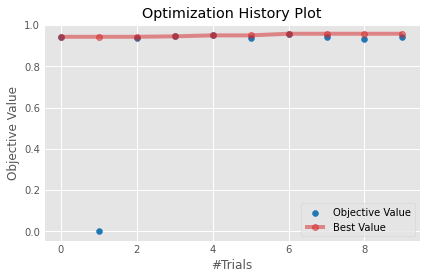

In [20]:
optuna.visualization.matplotlib.plot_optimization_history(study)

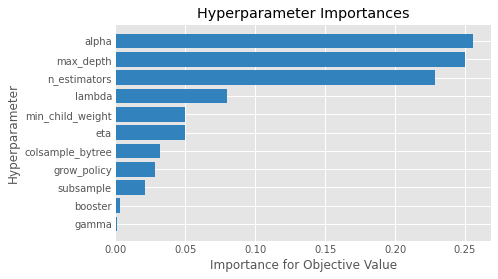

In [21]:
try:
    optuna.visualization.matplotlib.plot_param_importances(study)
except:
    print('Tuning only one hyper-parameter')

## Define and train model given the best hyperparameters

In [22]:
hyperparameters = best_trial_params

base_params = {"verbosity": 0,
               "objective": "binary:logistic",
               "tree_method": "hist",
               "n_jobs": -1}

hyperparameters.update(base_params)
print('Using these params:')
pprint(hyperparameters)
classifier = xgb.XGBClassifier(**hyperparameters)

Using these params:
{'alpha': 0.0974017552294485,
 'booster': 'dart',
 'colsample_bytree': 0.3797625913869255,
 'eta': 2.052993066463671e-07,
 'gamma': 3.390688901826367e-08,
 'grow_policy': 'lossguide',
 'lambda': 2.0466425002076884e-08,
 'max_depth': 3,
 'min_child_weight': 7,
 'n_estimators': 200,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'subsample': 0.49497745428756734,
 'tree_method': 'hist',
 'verbosity': 0}


In [23]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)
eval_set = [(X_train, y_train), (X_val, y_val)]

In [25]:
classifier.fit(X_train, 
               y_train,
               eval_set=[(X_train, y_train), (X_val, y_val)],
               eval_metric=['error', 'auc'],
               early_stopping_rounds=20,
               verbose=0)

XGBClassifier(alpha=0.0974017552294485, base_score=0.5, booster='dart',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.3797625913869255, eta=2.052993066463671e-07,
              gamma=3.390688901826367e-08, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              lambda=2.0466425002076884e-08, learning_rate=2.05299301e-07,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0974017531,
              reg_lambda=2.0466425e-08, scale_pos_weight=1,
              subsample=0.49497745428756734, tree_method='hist',
              validate_parameters=1, verbosity=0)

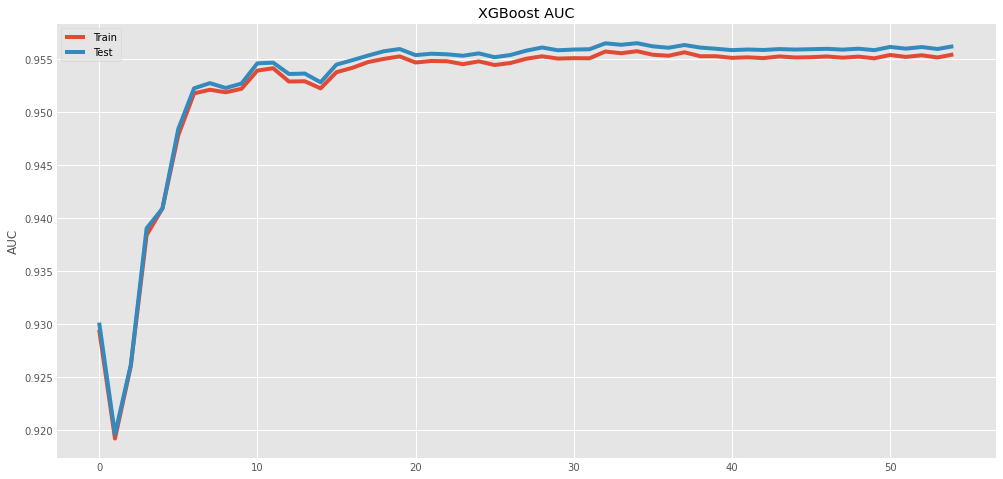

In [26]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

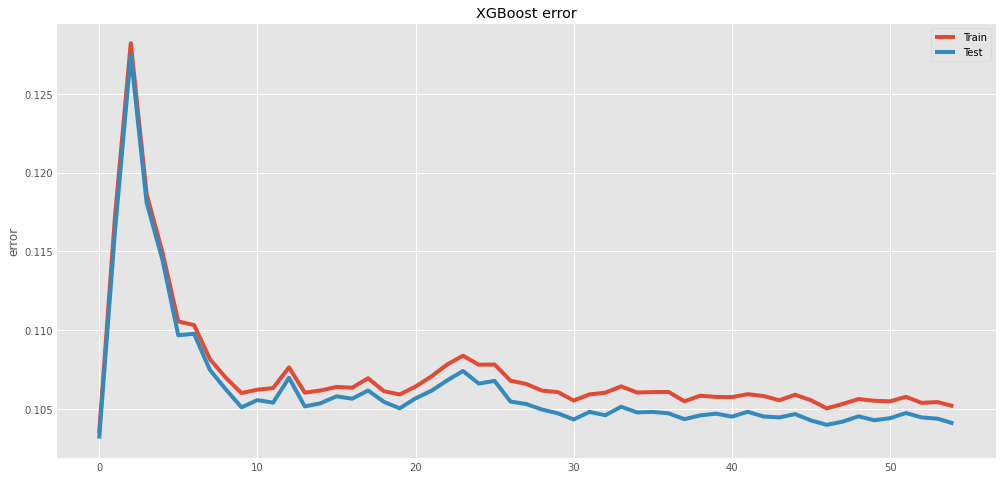

In [27]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('XGBoost error')
plt.show()

## Model testing and training/testing data validation

In [28]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_val)
prediction_probs = classifier.predict_proba(X_val)

In [29]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_val.astype(np.int16)

In [30]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_val, test_predictions))
# From docs: tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp = confusion_matrix(y_test_int, test_predictions).ravel()
recall = (tp / (tp + fp))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('\nTest Matthews Correlation Coefficient (MCC)')
print('-------------------------------------------------------')
mcc = matthews_corrcoef(y_test_int, test_predictions)
print(mcc)
print('\nConfusion Matrix')
print('-------------------------------------------------------')
print('TP: {:9} FN: {:9}'.format(tp, fn))
print('FP: {:9} TN: {:9}'.format(fp, tn))

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     51984
           1       0.96      0.82      0.88     48016

    accuracy                           0.90    100000
   macro avg       0.91      0.89      0.89    100000
weighted avg       0.90      0.90      0.89    100000

Test Recall
-------------------------------------------------------
0.959710010041882

Test Matthews Correlation Coefficient (MCC)
-------------------------------------------------------
0.7973261087323839

Confusion Matrix
-------------------------------------------------------
TP:     39184 FN:      8832
FP:      1645 TN:     50339


## Permutation importance

In [31]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_val,
                                                        y=y_val,
                                                        n_repeats=5,
                                                        random_state=42)

Saved to: /adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/mw_Golden_200_xgboost_2022_04_25_16_52_permutation_importance.png


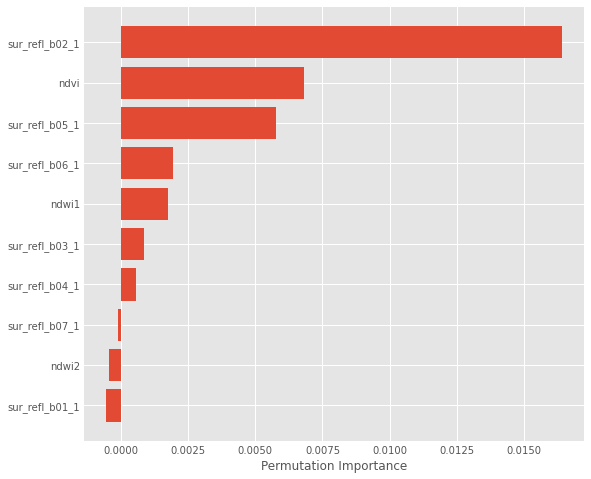

In [32]:
png_save_path = 'mw_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    hyperparameters['n_estimators'],
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)
print('Saved to: {}'.format(png_save_path))
sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_train.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

## Save the model for future use

In [33]:
model_save_path = 'mw_{}_{}_{}_4.0.0_tuned_{}.sav'.format(TILE,
                                                      hyperparameters['n_estimators'],
                                                      MODEL,
                                                      'gpu' if GPU else 'cpu',
                                                      datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_200_xgboost_4.0.0_tuned_gpu.sav
XGBClassifier(alpha=0.0974017552294485, base_score=0.5, booster='dart',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.3797625913869255, eta=2.052993066463671e-07,
              gamma=3.390688901826367e-08, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              lambda=2.0466425002076884e-08, learning_rate=2.05299301e-07,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0974017531,
              reg_lambda=2.0466425e-08, scale_pos_weight=1,
              subsample=0.49497745428756734, tree_method='hist',
              validate_parameters=1, verbosity=0)


['/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_200_xgboost_4.0.0_tuned_gpu.sav']

# Testing: Raster testing

In [34]:
TILE = 'h11v10'

In [35]:
DAY = 201
YEAR = 2006
PATH = os.path.join(test_data_basepath, '{}/'.format(TILE))

In [36]:
vars_list_gq = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list

['/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GQ.A2006201.h11v10.061.2020266164349-sur_refl_b01_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GQ.A2006201.h11v10.061.2020266164349-sur_refl_b02_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b03_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b04_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b05_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b06_1.tif',
 '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b07_1.tif']

## Get dimensions of inputs

In [37]:
vrt_opts = gdal.BuildVRTOptions(separate=True)
dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_opts)
nrows, ncols = dd.RasterYSize, dd.RasterXSize
dd = None
if os.path.exists('tmp.vrt'):
    os.remove('tmp.vrt') 
nrows, ncols

(4800, 4800)

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [38]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [39]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 282 2985  173 ... 8273 2822 6797]
 [ 289 3045  173 ... 8266 2913 6851]
 [ 275 3198  180 ... 8416 3050 6898]
 ...
 [ 317 1559  144 ... 6620  562 4395]
 [ 252 1447  126 ... 7033  770 4863]
 [ 252 1447  126 ... 7033  770 4863]]
460.8 MB size


In [40]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [41]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

Making predictions from raster
CPU times: user 35min, sys: 1.27 s, total: 35min 1s
Wall time: 1min 4s


In [42]:
shp = (4800, 4800)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

## Inputreshapet raster: description and histogram

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,23040000.0,1140.560665,1527.279099,-28672.0,227.0,463.0,1397.0,11069.0
sur_refl_b02_1,23040000.0,2658.499274,1132.979425,-28672.0,2082.0,2533.0,2899.0,10802.0
sur_refl_b03_1,23040000.0,829.334512,1460.147104,-28672.0,152.0,242.0,685.0,9552.0
sur_refl_b04_1,23040000.0,1086.797176,1447.336811,-28672.0,356.0,496.0,1055.0,10207.0
sur_refl_b05_1,23040000.0,2919.611193,1008.000270,-28672.0,2444.0,2757.0,3154.0,8725.0
sur_refl_b06_1,23040000.0,2214.756003,1198.891539,-28672.0,1332.0,1835.0,2798.0,7891.0
sur_refl_b07_1,23040000.0,1316.849571,1626.572310,-28672.0,431.0,873.0,2086.0,8951.0
ndvi,23040000.0,5099.909421,3622.130717,-32758.0,1772.0,6266.0,8435.0,32762.0
ndwi1,23040000.0,1035.434987,2495.314006,-32758.0,-812.0,825.0,3330.0,32762.0
ndwi2,23040000.0,3787.883306,3553.893702,-32758.0,542.0,4209.0,7222.0,32762.0


#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [44]:
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [45]:
qa_list = [fn for fn in glob.glob(os.path.join(qaMaskPath, '{}/*A{}{:03}.{}*.tif'.format(TILE, YEAR, DAY, TILE)))]
try:
    qa_mask = qa_list[0]
    print(qa_mask)
    ds = gdal.Open(qa_mask, gdal.GA_ReadOnly)
    qaMaskMatrix = ds.GetRasterBand(1).ReadAsArray().astype(np.int16)
except Exception:
    path = os.path.join(qaMaskPath, '{}/*A{}{:03}.{}*.tif'.format(TILE, YEAR, DAY, TILE))
    print('Could not find QA mask at {}'.format(path))
    qaMaskMatrix = np.zeros((4800, 4800))

/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa/h11v10/MOD.A2006201.h11v10.20220601214.QA.tif


In [46]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

/adapt/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/*h11v10*.tif
/adapt/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v10_2006_v5.tif


In [47]:
waterMaskMatrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int16)

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [48]:
maskedResult = np.where(qaMaskMatrix == 0, reshp, -9999)
maskedResultProba = np.where(qaMaskMatrix == 0, probaWater, -9999)
waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, -9999)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

In [49]:
np.unique(qaMaskMatrix)

array([0, 1], dtype=int16)

# Generating stats for predicted and truth

## Predicted Raster

In [50]:
import math

In [51]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))
mcc_denom_nosqrt = (truePositives+falsePositives)*(truePositives+falseNegatives)*(trueNegatives+falsePositives)*(trueNegatives+falseNegatives)
mcc_numerator = (truePositives*trueNegatives) - (falsePositives*falseNegatives)
mcc = mcc_numerator/math.sqrt(mcc_denom_nosqrt)

### Count num of occurences for each class with the masked predicted result

In [52]:
countNoData = np.count_nonzero(maskedResult == -9999)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 5671456
 Land occurance: 16360575
 Water occurances: 1007969


### Count num of occurences for each class with the water mask

In [53]:
countNoDataT = np.count_nonzero(waterMasked == -9999)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 5671456
 Land occurance: 17043705
 Water occurances: 324839


### Model metrics on raster data

In [54]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))
print('MCC: {}'.format(mcc))

Metrics of Accuracy for Raster Test Data
True Positives:  293347
True Negatives:  16329083
False Positives: 714622
False Negatives: 31492
Total "good" data: 17368544
Accuracy*: 0.9570422253010961
Precision: 0.291027799466055
Recall: 0.9030535126631962
f1: 0.4401939364109459
MCC: 0.4989525805922397


## Output predicted raster to GeoTiff

In [55]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output probabilies raster masked by good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPathProba, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResultProba)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_xgboost.tif
/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/waterMask_2006_qa_201.tif
/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_probabilities_xgboost.tif
Transform
(-7783653.637667, 231.656358, 0.0, -1111950.519667, 0.0, -231.656358)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800


## Folium viewing

In [56]:
import folium
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 

In [57]:
# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

In [58]:
mask_3857 = reproject_to_3857(outPath)
probW_3857 = reproject_to_3857(outPathProba)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask)

mask_d = get_bounds(mask_3857)
probw_d = get_bounds(probW_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
probw_b1 = open_and_get_band(probW_3857, 1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
mod44_b1 = np.where(mod44_b1 == -9999, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(probW_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
probw_rgb = np.dstack((zeros, zeros, probw_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292471.14|
| 0.00,-207.27,-1118891.21|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568


In [59]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)

In [60]:
from folium import plugins

In [61]:
m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(probw_rgb, probw_d, '{}-{}-{} model proba water'.format(YEAR, DAY, TILE), opacity=0.35, show=False))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())